In [310]:
#pip install XlsxWriter
#pip install pandas
#pip install numpy
#pip install matplotlib

Import Packages and Set Parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

root_path = './'
input_filepath = 'input data/'
output_filepath = 'output file/'
selected_quarter = '2021 Q2'
output_filename = selected_quarter + '_HC & PO report.xlsx'
top_k = 15
headcount_file_1 = '202103HC.csv'
headcount_file_2 = '202106HC.csv'
purchaseoder_file_1 = 'PO Details2021Q1.csv'
purchaseoder_file_2 = 'PO Details2021Q2.csv'

Define Functions

In [2]:
def format_y_ticks(value, _):
    if value >= 1000:
        value = f'{value/1000:,.0f}k'
    return value

def get_quarter(input_date):
    year, month, day = map(int, input_date.split('-'))
    quarter = (month - 1) // 3 + 1
    result = f"{year} Q{quarter}"
    return result

Headcount Data

In [3]:
# import and clean data
HC_1 = pd.read_csv(root_path + input_filepath + headcount_file_1)
HC_2 = pd.read_csv(root_path + input_filepath + headcount_file_2)

HC_1['Employee WWID'] = HC_1['Employee WWID'].astype(str)
HC_2['Employee WWID'] = HC_2['Employee WWID'].astype(str)

HC_1 = HC_1.loc[HC_1['Region'] == 'APJC']
HC_2 = HC_2.loc[HC_2['Region'] == 'APJC']


In [4]:
# get employee attrition and join during the period
def Diff(li1, li2): 
    return (list(set(li1).symmetric_difference(set(li2))))
dif = Diff(HC_1['Employee WWID'], HC_2['Employee WWID'])

# employee out
x = []
for a in HC_1['Employee WWID']:
    if a in dif:
        x.append(a)
HC_out = HC_1.loc[HC_1['Employee WWID'].isin(x)]
HC_out.to_csv(root_path + output_filepath + 'Headcount_Out.csv')

# employee in
y = []
for a in HC_2['Employee WWID']:
    if a in dif:
        y.append(a)
HC_in = HC_2.loc[HC_2['Employee WWID'].isin(y)]
HC_in.to_csv(root_path + output_filepath + 'Headcount_In.csv')

# all employee
HC = pd.concat([HC_1, HC_2], ignore_index=True)
HC = HC.drop_duplicates()


Purchase Order Data

In [5]:
# import and clean data
PO_1 = pd.read_csv(root_path + input_filepath + purchaseoder_file_1)
PO_2 = pd.read_csv(root_path + input_filepath + purchaseoder_file_2) 
PO = pd.concat([PO_1,PO_2])
PO.to_csv(root_path + output_filepath + 'Purchase_Order.csv')

Merge Headcount and Purchase order data

In [6]:
# merge the data on "Employee WWID" and "PO Requestor WWID"
merge = pd.merge(HC, PO, how='inner', left_on='Employee WWID', right_on='PO Requestor WWID')
merge_1 = pd.merge(HC_out, PO, how='inner', left_on='Employee WWID', right_on='PO Requestor WWID')
merge_2 = pd.merge(HC_in, PO, how='inner', left_on='Employee WWID', right_on='PO Requestor WWID')

# combine the sheets into workbook & export the report
dfs = {'PO to be tracked':merge_1, 'Headcount_in':HC_in, 'Headcount_out':HC_out} 
writer = pd.ExcelWriter(root_path + output_filepath + output_filename, engine='xlsxwriter')
for sheet_name in dfs.keys():
    dfs[sheet_name].to_excel(writer, sheet_name=sheet_name, index=False) 
writer.close()

Analyze the Data

In [7]:
# identify the cost center with the highest Total Net Amount $ of PO
df = merge[['Cost Center Code','Cost Center Name','PO Net Amt $']]
df_amt = df.groupby(['Cost Center Code','Cost Center Name']).agg(Sum_of_PO_Net_Amt=('PO Net Amt $','sum'))
df_amt = df_amt.sort_values(by='Sum_of_PO_Net_Amt', ascending=False).head(top_k)
df_amt = df_amt.reset_index()

In [8]:
# identify the cost center with the most PO open
df = merge[['Cost Center Code','Cost Center Name']]
df_freq = df.groupby(['Cost Center Code','Cost Center Name']).agg(Count=('Cost Center Code','count'))
df_freq = df_freq.sort_values(by='Count', ascending=False).head(top_k)
df_freq = df_freq.reset_index()

Create the Graph

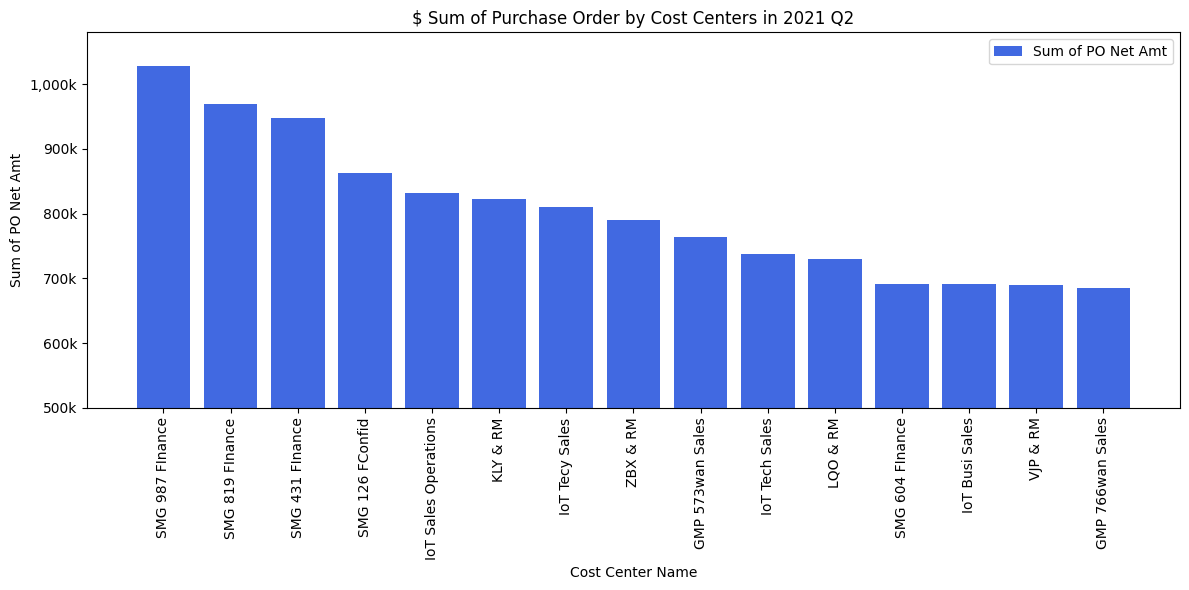

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(df_amt['Cost Center Name'], df_amt['Sum_of_PO_Net_Amt'], color='royalblue', label = 'Sum of PO Net Amt')
plt.xlabel('Cost Center Name')
plt.xticks(rotation=90)
plt.ylabel('Sum of PO Net Amt')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
plt.ylim(bottom=500000) 
plt.title('$ Sum of Purchase Order by Cost Centers in ' + selected_quarter)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(root_path + output_filepath + 'PO_total$.jpg')

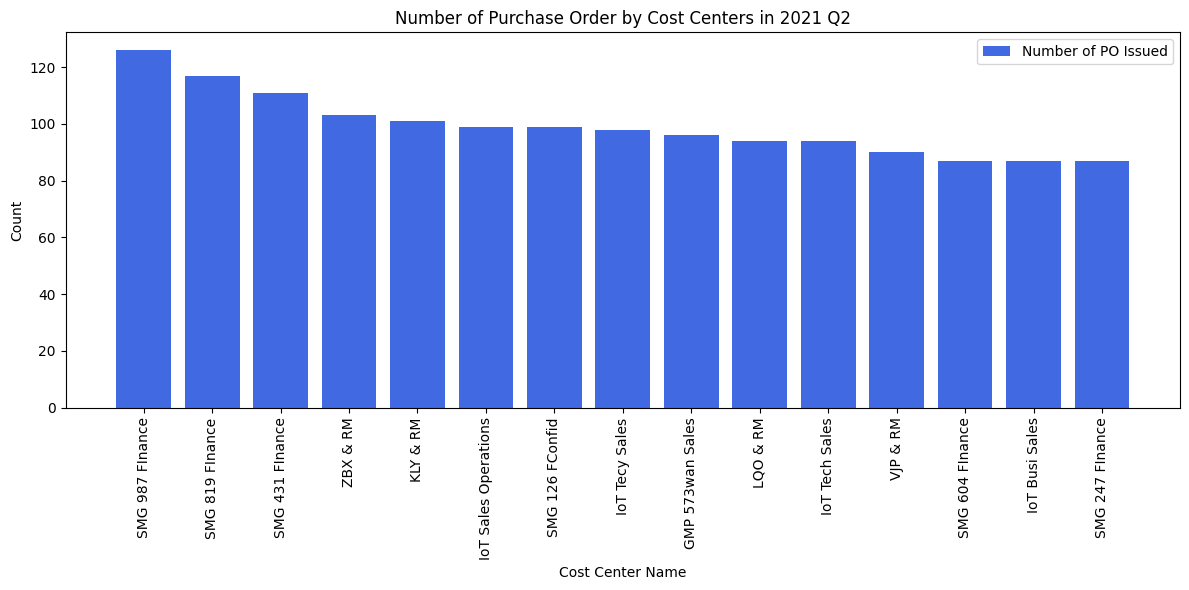

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(df_freq['Cost Center Name'], df_freq['Count'], color='royalblue', label = 'Number of PO Issued')
plt.xlabel('Cost Center Name')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Number of Purchase Order by Cost Centers in ' + selected_quarter)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(root_path + output_filepath + 'PO_num.jpg')

In [11]:
# hc in and out
df_in = HC_in.groupby(['Cost Center Code','Cost Center Name']).agg(join=('Cost Center Code','count'))
df_in = df_in.reset_index()

df_out = HC_out.groupby(['Cost Center Code','Cost Center Name']).agg(attrition = ('Cost Center Code','count'))
df_out = df_out.reset_index()

HC_inout = pd.merge(df_in, df_out, on='Cost Center Name')
HC_inout = HC_inout[['Cost Center Name', 'join','attrition']]
HC_inout['attrition'] = HC_inout['attrition'] * (-1)

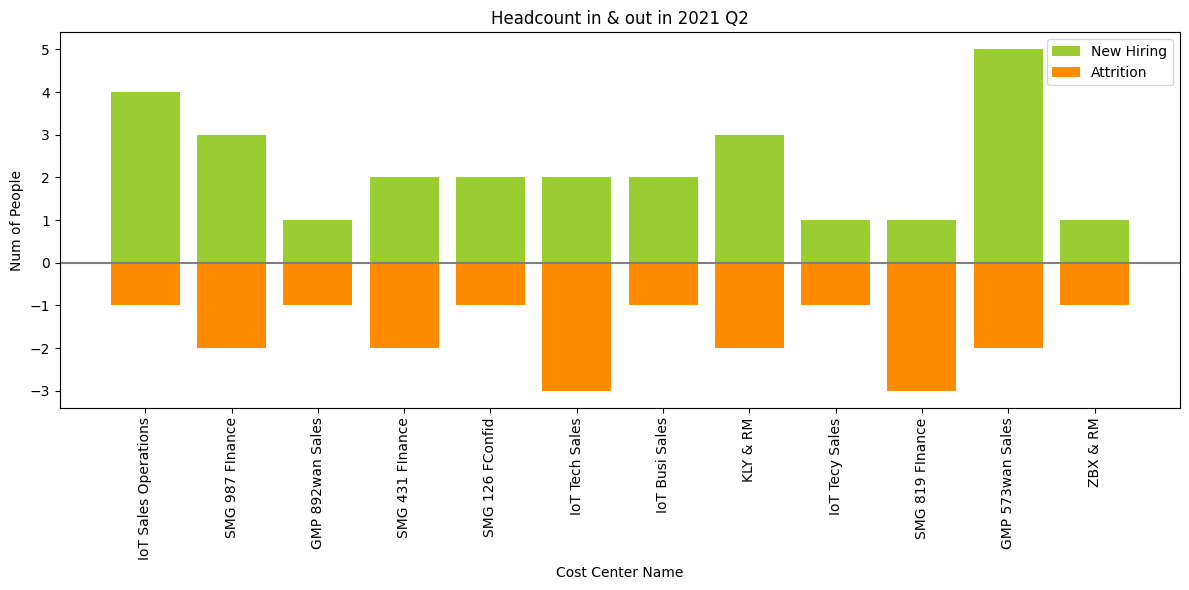

In [12]:
# Headcount in and out

plt.figure(figsize=(12, 6))
plt.bar(HC_inout['Cost Center Name'], HC_inout['join'], color='yellowgreen', label='New Hiring')
plt.bar(HC_inout['Cost Center Name'], HC_inout['attrition'], color='darkorange', label='Attrition')
plt.xlabel('Cost Center Name')
plt.xticks(rotation=90)
plt.ylabel('Num of People')
plt.title('Headcount in & out in '+ selected_quarter)
plt.legend(loc='upper right')
plt.axhline(y=0, color='gray', linestyle='-')
plt.tight_layout()
plt.savefig(root_path + output_filepath + 'HC_in_out.jpg')

In [13]:
# list of people to train

train = merge_1[['Employee WWID', 'Region', 'Country', 'Business Unit','Cost Center Code', 'Cost Center Name']]
train = train.drop_duplicates()
train.to_csv(root_path + output_filepath + 'Training List.csv')

In [14]:
# list of people to monitor

merge_2['Quarter'] = merge_2['PO Validity End Date'].apply(get_quarter)
monitor = merge_2[merge_2['Quarter'] > selected_quarter]
monitor.drop('Quarter', axis=1, inplace=True)
monitor.to_csv(root_path + output_filepath + 'Risk Potential PO.csv')


C:\Users\Victoria\AppData\Local\Temp\ipykernel_8804\1817834174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitor.drop('Quarter', axis=1, inplace=True)
